<a href="https://colab.research.google.com/github/hector6298/Deep-Learning-Collab-notebooks/blob/master/horizon_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt
!mkdir outframes

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 372, done.
remote: Total 372 (delta 0), reused 0 (delta 0), pack-reused 372
Receiving objects: 100% (372/372), 4.17 MiB | 3.37 MiB/s, done.
Resolving deltas: 100% (216/216), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 21kB/s 
     |████████████████████████████████| 28.7MB 111kB/s 
     |████████████████████████████████| 3.9MB 52.7MB/s 
     |████████████████████████████████| 450kB 47.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=c4c7caa80727aa3d96be854a2d819f8e930dcd3e2d688381fce5a001005d1de7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2

In [3]:
!ls

import tensorflow as tf
tf.__version__

checkpoints	 data		  outframes		tools
colab_gpu.ipynb  detect.py	  README.md		train.py
conda-cpu.yml	 detect_video.py  requirements-gpu.txt	yolov3_tf2
conda-gpu.yml	 docs		  requirements.txt	yolov3_tf2.egg-info
convert.py	 LICENSE	  setup.py


'2.1.0'

In [4]:
!mkdir data
!cp "/content/drive/My Drive/YOLO_weights/yolov3.weights" "data/yolov3.weights"
!python convert.py


mkdir: cannot create directory ‘data’: File exists
2020-05-29 02:09:49.581163: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-05-29 02:09:49.581261: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-05-29 02:09:49.581291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-05-29 02:09:50.393202: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-29 02:09:

In [0]:
!cp "/content/drive/My Drive/rectification.py" rectification.py

In [0]:
from absl import app, flags, logging
from absl.flags import FLAGS
from IPython.display import clear_output
import numpy as np
import tensorflow as tf
import cv2
import time
from skimage import feature, color, transform, io
from google.colab.patches import cv2_imshow
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images
from yolov3_tf2.utils import draw_outputs
import math
from rectification import *


In [0]:
OUTPATH = None
CLASSES = ['car', 'truck', 'bus']
NCLASSES = len(CLASSES)
WEIGHTSPATH = "/content/yolov3-tf2/checkpoints/yolov3.tf"
YOLOSIZE = 416
TINY_YOLO = False
VIDEOPATH = "/content/drive/My Drive/coco/speed_DS/v6.avi"
app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [0]:
def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    boxpoints = []
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        boxpoints.append((x1y1[0], x1y1[1], x2y2[0], x2y2[1]))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        #img = cv2.putText(img, '{} {:.4f}'.format(
         ##  x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img, boxpoints

In [0]:
def draw_lines_with_angle(img, draw, angleLow, angleHigh):
  lines = transform.probabilistic_hough_line(img, line_length=35, line_gap=1)
  LineImg = np.zeros_like(img)
  for p0, p1 in lines:
    delta = np.array(p1) - np.array(p0)
    theta = np.arctan(float(delta[1])/delta[0])
    if theta > (np.pi/180)*angleLow and theta < (np.pi/180)*angleHigh:
      LineImg = cv2.line(draw, p0, p1, (255,0,255), 2)
  return LineImg, lines

In [0]:
def mod_edgelets(image, boxPoints, angleLow, angleHigh, sigma=3):
  edges = cv2.Canny(image, 100, 200)
  for boxpoint in boxPoints:
    edges = cv2.rectangle(edges, (boxpoint[0],boxpoint[1]), (boxpoint[2],boxpoint[3]), (0,0,0),2 )
  lines = transform.probabilistic_hough_line(edges, line_length=3,
                                              line_gap=2)

  locations = []
  directions = []
  strengths = []

  for p0, p1 in lines:
    delta = np.array(p1) - np.array(p0)
    theta = np.arctan(float(delta[1])/delta[0])
    if theta > (np.pi/180)*angleLow and theta < (np.pi/180)*angleHigh:
      p0, p1 = np.array(p0), np.array(p1)
      locations.append((p0 + p1) / 2)
      directions.append(p1 - p0)
      strengths.append(np.linalg.norm(p1 - p0))

  return (locations, directions, strengths)

In [0]:
def normalize_edgelets(edgelets):
    # convert to numpy arrays and normalize
  locations, directions, strengths = edgelets
  locations = np.array(locations)
  directions = np.array(directions)
  strengths = np.array(strengths)

  directions = np.array(directions) / \
      np.linalg.norm(directions, axis=1)[:, np.newaxis]
  return (locations, directions, strengths)

In [12]:
if TINY_YOLO:
    yolo = YoloV3Tiny(classes=80)
else:
    yolo = YoloV3(classes=80)

yolo.load_weights(WEIGHTSPATH)
logging.info('weights loaded')

class_names = CLASSES
logging.info('classes loaded')

I0529 02:10:14.631229 140626538346368 <ipython-input-12-d4cb14b9da49>:7] weights loaded
I0529 02:10:14.632208 140626538346368 <ipython-input-12-d4cb14b9da49>:10] classes loaded


In [18]:

times = []

vid = cv2.VideoCapture(VIDEOPATH)
fps = int(vid.get(cv2.CAP_PROP_FPS))
width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

lines_img = np.zeros((height,width))

locations = []
directions = []
strengths = []

for f in range(fps*120):
  if f % 5 == 0:
    clear_output(wait=True)
    _, img = vid.read()
    
    if img is None:
      logging.warning("Empty Frame")
      time.sleep(0.1)
      continue
    mask = np.zeros((height, width))
    grayFrame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_in = tf.expand_dims(img_in, 0)
    img_in = transform_images(img_in, YOLOSIZE)

    t1 = time.time()
    boxes_, scores_, classes_, nums_ = yolo.predict(img_in)
    
    img, boxPoints = draw_outputs(img, (boxes_, scores_, classes_, nums_), class_names)
    for boxpoint in boxPoints:
      mask[boxpoint[1]:boxpoint[3]+1, boxpoint[0]:boxpoint[2]+1] = 1

    frameMasked = (grayFrame*mask)*255.0
    frameMasked = frameMasked.astype('uint8')
    #boxesEdges = cv2.Canny(frameMasked, 100, 200)
    locations_, directions_, strengths_ = mod_edgelets(frameMasked, boxPoints, -10, 10)
    for i in range(len(locations_)):
      locations.append(locations_[i])
      directions.append(directions_[i])
      strengths.append(strengths_[i])
    #lines_img_ = draw_lines_with_angle(boxesEdges, lines_img, -10, 10)
    print(f"done {f/fps}")

edgelets_cars = normalize_edgelets((locations, directions, strengths))


done 119.9


In [20]:
edgelets_road = compute_edgelets(img)


vp1 = ransac_vanishing_point(edgelets_road, num_ransac_iter=5000, 
                             threshold_inlier=5)
vp2 = ransac_vanishing_point(edgelets_cars, num_ransac_iter=5000, 
                             threshold_inlier=5)

/content/yolov3-tf2/rectification.py:121: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.abs(cosine_theta))
/content/yolov3-tf2/rectification.py:124: RuntimeWarning: invalid value encountered in less
  return (theta < theta_thresh) * strengths
I0529 02:24:19.520898 140626538346368 rectification.py:182] Current best model has 6886.603991311451 votes at iteration 0
I0529 02:24:19.522436 140626538346368 rectification.py:182] Current best model has 7117.470487008118 votes at iteration 2
I0529 02:24:19.524718 140626538346368 rectification.py:182] Current best model has 7352.747460778213 votes at iteration 5
I0529 02:24:19.526852 140626538346368 rectification.py:182] Current best model has 7473.41564699027 votes at iteration 8
I0529 02:24:19.531635 140626538346368 rectification.py:182] Current best model has 7631.760633024827 votes at iteration 19
I0529 02:24:19.538930 140626538346368 rectification.py:182] Current best model has 7687.158778701226 votes at iteratio

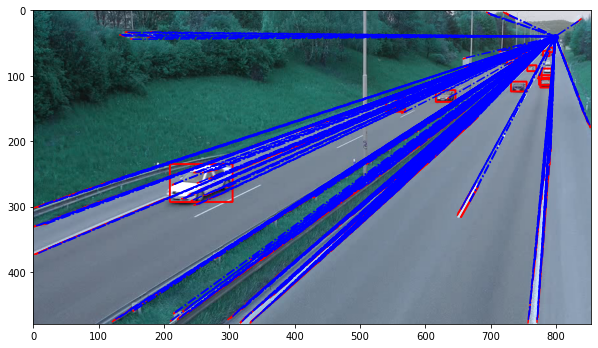

In [21]:
vis_model(img, vp1)

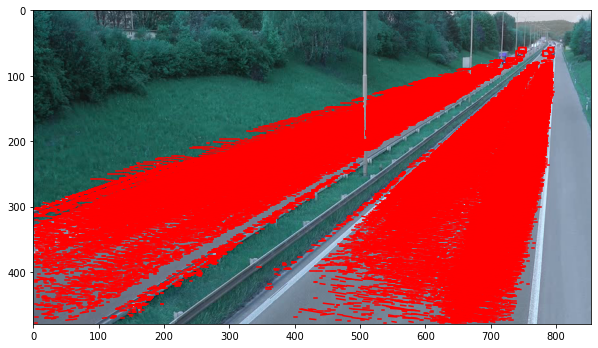

In [24]:
vis_edgelets(img, edgelets_cars)

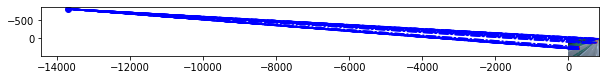

In [23]:
vis_model(img, vp2)

In [0]:
vanishing_point_road = vp1/vp1[2]
vanishing_point_cars = vp2/vp2[2]

In [0]:
def draw_horizon(image, vp1, vp2):
  slope = float(vp2[1] - vp1[1]) / (vp2[0] - vp1[0])
  y1 = -slope*vp2[0] + vp2[1]
  y3 = slope*image.shape[1] + y1 

  y1, y3 = int(y1), int(y3)

  pt1 = (0,y1)
  pt2 = (image.shape[1], y3)

  return cv2.line(image, pt1, pt2, (255,0,255), thickness=2)

In [0]:
horizon = draw_horizon(img, vanishing_point_road, vanishing_point_cars)

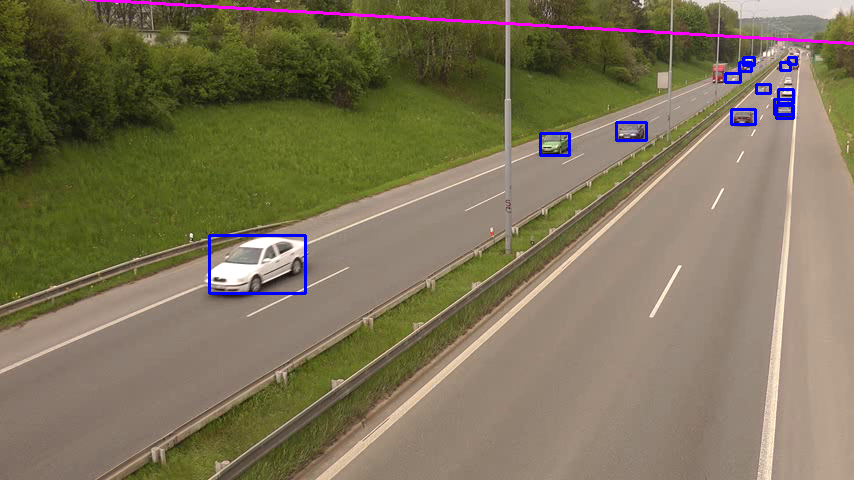

In [48]:
cv2_imshow(horizon)